# Проект "Прогнозирование оттока клиентов ТелеДом"

## Цель проекта
Разработка модели машинного обучения для прогнозирования оттока клиентов оператора связи "ТелеДом" с целью своевременного предложения персональных условий и удержания абонентов.

## Описание данных

### Источники данных
База данных SQLite, содержащая 4 таблицы:
1. `contract` - информация о договорах
2. `personal` - персональные данные клиентов
3. `internet` - данные об интернет-услугах
4. `phone` - данные о телефонных услугах

## Таблицы и поля

### Таблица `contract` (Договоры)
- `customerID` - Уникальный идентификатор клиента
- `BeginDate` - Дата начала действия договора
- `EndDate` - Дата расторжения договора (NULL для действующих клиентов)
- `Type` - Периодичность оплаты: "Ежемесячно" или "Ежегодно"
- `PaperlessBilling` - Использование электронных счетов (Да/Нет)
- `PaymentMethod` - Способ оплаты: "Электронный чек", "Кредитная карта" и др.
- `MonthlyCharges` - Размер ежемесячного платежа
- `TotalCharges` - Общая сумма выплат клиента

### Таблица `personal` (Персональные данные)
- `customerID` - Уникальный идентификатор клиента
- `gender` - Пол клиента
- `SeniorCitizen` - Пенсионный статус
- `Partner` - Наличие супруга/супруги
- `Dependents` - Наличие детей

### Таблица `internet` (Интернет-услуги)
- `customerID` - Уникальный идентификатор клиента
- `InternetService` - Тип подключения
- `OnlineSecurity` - Подписка на интернет-безопасность
- `OnlineBackup` - Подписка на облачное резервное копирование
- `DeviceProtection` - Антивирус
- `TechSupport` - Техническая поддержка
- `StreamingTV` - Стриминговое ТВ
- `StreamingMovies` - Каталог фильмов

### Таблица `phone` (Телефонные услуги)
- `customerID` - Уникальный идентификатор клиента
- `MultipleLines` - Подключение телефона к нескольким линиям одновременно.

## Особенности данных
- Данные актуальны на 1 февраля 2020 года

## Задачи анализа
1. Определить ключевые факторы оттока клиентов
2. Построить прогнозную модель ухода абонентов
3. Выделить сегменты клиентов с высоким риском оттока
4. Разработать рекомендации по удержанию клиентов

In [2]:
# установка модулей
!pip install phik -q
!pip install scikit-learn==1.6.0 -q
!pip install shap -q
!pip install matplotlib==3.9.2 -q

In [3]:
import urllib.request
import os
import os.path
from tabulate import tabulate
import pandas as pd
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
import phik
import random
import shap

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder, 
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    make_scorer
)

In [404]:
# объявление констант
DB_PATH = "data/"
DB_FILE = "ds-plus-final.db"
DB_URL = "https://code.s3.yandex.net/data-scientist/ds-plus-final.db"
DB_TABLE_NAMES = ['contract', 'personal', 'internet', 'phone']
DB_TABLE_DICT = {
    "contract": [
        "customerID",
        "BeginDate",
        "EndDate",
        "Type",
        "PaperlessBilling",
        "PaymentMethod",
        "MonthlyCharges",
        "TotalCharges"
    ],
    "personal": [
        "customerID",
        "gender",
        "SeniorCitizen",
        "Partner",
        "Dependents"
    ],
    "internet": [
        "customerID",
        "InternetService",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies"
    ],
    "phone": [
        "customerID",
        "MultipleLines"
    ]
}                  
RANDOM_STATE = 110825
TEST_SIZE = .25
TARGET_METRIC = .85
TARGET = "IsCancel"

In [316]:
# настройка стиля графиков
sns.set(style="whitegrid", palette="pastel")

# 1. Первичный осмотр данных

In [6]:
# создаем каталог для хранения БД
if not os.path.exists(DB_PATH):
    try:
        os.makedirs(DB_PATH)
        print(f"Каталог {DB_PATH} создан")
    except Exception as err:
        print(f"Ошибка при создании каталога 'data': {err}")

In [7]:
# загружаем файл с БД
if not os.path.exists(DB_PATH+DB_FILE):
    try:
        urllib.request.urlretrieve(DB_URL, DB_PATH+DB_FILE)
        print(f"База данных {DB_FILE} загружена")
    except Exception as err:
        print(f"Ошибка при попытке загрузки базы данных {err}")
else:
    print(f"База данных {DB_FILE} уже загружена")

База данных ds-plus-final.db уже загружена


In [8]:
# подключаемся к БД
engine = create_engine(f'sqlite:///{DB_PATH+DB_FILE}', echo=False) 

### TableGetInfo

Класс для проверки структуры и анализа данных в таблицах базы данных.

### Основной функционал

- Валидация структуры таблиц (соответствие ожидаемым столбцам)
- Анализ метаинформации (типы данных, NULL-значения)
- Подсчет уникальных значений
- Просмотр образцов данных

### Конструктор класса
`__init__(self, engine, tables_dict=None)` - Инициализирует анализатор с подключением к БД и словарем таблиц.

### Внутренние методы

`_get_table_info(table_name)` - Получает метаинформацию о структуре указанной таблицы.

`_check_null_values(table_name)` - Подсчитывает количество NULL-значений для каждого столбца таблицы.

`_get_table_size(table_name)` - Считает общее количество строк в указанной таблице.

`_unique_counts(table_name, columns)` - Вычисляет количество уникальных значений для указанных столбцов.

`_validate_tables()` - Основной метод валидации, проверяет все таблицы из словаря.

### Публичные методы

`print_info()` - Выводит форматированный отчет о структуре таблиц и их данных.

`show_data(limit=5)` - Отображает первые N строк из каждой таблицы для предварительного просмотра.

In [10]:
class TableGetInfo:
    def __init__(self, engine, tables_dict=None):
        if not tables_dict:
            raise ValueError('Словарь tables_dict не может быть пустым')
        self.engine = engine
        self.tables_dict = tables_dict
        self.results = {}
        self._validate_tables()
    
    def _get_table_info(self, table_name):
        try:
            query = text(f"PRAGMA table_info({table_name})")
            return pd.read_sql_query(query, con=self.engine)
        except SQLAlchemyError as e:
            print(f"Ошибка при получении информации о таблице {table_name}: {e}")
            return None
            
    def _check_null_values(self, table_name):
        null_counts = {}
        try:
            for column in self.tables_dict[table_name]:
                query = text(f"SELECT COUNT(*) FROM {table_name} WHERE {column} IS NULL")
                null_count = pd.read_sql_query(query, self.engine).iloc[0, 0]
                if null_count > 0:
                    null_counts[column] = null_count
        except SQLAlchemyError as e:
            print(f"Ошибка при проверке NULL-значений в {table_name}.{column}: {e}")
        return null_counts
        
    def _get_table_size(self, table_name):
        query = text(f'SELECT COUNT(*) FROM {table_name}')
        try:
            return pd.read_sql_query(query, con=self.engine).iloc[0,0]
        except SQLAlchemyError as e:
            print(f"Ошибка при выполнении запроса: {e}")
            return None
            
    def _unique_counts(self, table_name, columns):
        value_counts = {}
        for col in columns:
            query = text(f"SELECT COUNT(DISTINCT UPPER({col})) FROM {table_name}")
            value_counts[col] = pd.read_sql_query(query, engine).iloc[0,0]
        return value_counts
        
    def _validate_tables(self):        
        for table_name, expected_columns in self.tables_dict.items():
            actual_info = self._get_table_info(table_name)
            actual_columns = actual_info['name'].tolist()
            missing_in_db = set(expected_columns) - set(actual_columns)
            extra_in_db = set(actual_columns) - set(expected_columns)
            self.results[table_name] = {
                'status': 'ok' if not missing_in_db and not extra_in_db else 'mismatch',
                'table_size': self._get_table_size(table_name),
                'actual_columns': actual_columns,
                'value_counts': self._unique_counts(table_name, actual_columns),
                'missing_columns': list(missing_in_db),
                'extra_columns': list(extra_in_db),
                'column_types': dict(zip(actual_info['name'], actual_info['type'])),
                'null_values': self._check_null_values(table_name)
            }

    def print_info(self):
        for table_name, data in self.results.items():
            print(f"\nТаблица: {table_name}")
            print("-" * 50)
            
            if data['status'] == 'ok':
                print("✅ Структура полностью соответствует ожидаемой")
            else:
                if data['missing_columns']:
                    print(f"❌ Отсутствующие столбцы: {', '.join(data['missing_columns'])}")
                if data['extra_columns']:
                    print(f"❌ Лишние столбцы в БД: {', '.join(data['extra_columns'])}")

            print(f"\nКоличество строк: {data['table_size']}")
          
            if data['null_values']:
                print("\nПропущенные значения (NULL):")
                for col, count in data['null_values'].items():
                    print(f"  - {col}: {count} пропусков")
            else:
                print("\nПропусков(NULL) нет")
                    
            print("\nПроверка столбцов, типов и уникальных значений:")
            for col in data['actual_columns']:
                status = "🔴" if col in data['missing_columns'] or col in data['extra_columns'] else "🟢"
                col_type = data['column_types'].get(col)
                value_counts = data['value_counts'].get(col)
                print(f"{status} {col}: {col_type}: {value_counts}")            
            print("-" * 50)

    def show_data(self, limit=5):
        for table_name in self.tables_dict.keys():
            try:
                query = text(f"SELECT * FROM {table_name} LIMIT {limit}")
                df = pd.read_sql_query(query, self.engine)
                
                print(f"\n{'-'*50}")
                print(f"Таблица: {table_name} (первые {limit} записей)")
                print('-'*50)
                print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

            except Exception as e:
                print(f"\nОшибка при обработке таблицы {table_name}: {str(e)}")

In [11]:
# инициализация 
analyzer = TableGetInfo(engine=engine, tables_dict=DB_TABLE_DICT)

In [12]:
# запуск валидаци таблиц БД
analyzer.print_info()


Таблица: contract
--------------------------------------------------
✅ Структура полностью соответствует ожидаемой

Количество строк: 7043

Пропусков(NULL) нет

Проверка столбцов, типов и уникальных значений:
🟢 customerID: TEXT: 7043
🟢 BeginDate: TEXT: 77
🟢 EndDate: TEXT: 67
🟢 Type: TEXT: 3
🟢 PaperlessBilling: TEXT: 2
🟢 PaymentMethod: TEXT: 4
🟢 MonthlyCharges: TEXT: 1585
🟢 TotalCharges: TEXT: 6658
--------------------------------------------------

Таблица: personal
--------------------------------------------------
✅ Структура полностью соответствует ожидаемой

Количество строк: 7043

Пропусков(NULL) нет

Проверка столбцов, типов и уникальных значений:
🟢 customerID: TEXT: 7043
🟢 gender: TEXT: 2
🟢 SeniorCitizen: TEXT: 2
🟢 Partner: TEXT: 2
🟢 Dependents: TEXT: 2
--------------------------------------------------

Таблица: internet
--------------------------------------------------
✅ Структура полностью соответствует ожидаемой

Количество строк: 5517

Пропусков(NULL) нет

Проверка столбц

In [13]:
analyzer.show_data()


--------------------------------------------------
Таблица: contract (первые 5 записей)
--------------------------------------------------
+--------------+-------------+-----------+----------------+--------------------+---------------------------+------------------+----------------+
| customerID   | BeginDate   | EndDate   | Type           | PaperlessBilling   | PaymentMethod             |   MonthlyCharges |   TotalCharges |
|--------------+-------------+-----------+----------------+--------------------+---------------------------+------------------+----------------|
| 7590-VHVEG   | 2020-01-01  | No        | Month-to-month | Yes                | Electronic check          |            29.85 |          31.04 |
| 5575-GNVDE   | 2017-04-01  | No        | One year       | No                 | Mailed check              |            56.95 |        2071.84 |
| 3668-QPYBK   | 2019-10-01  | No        | Month-to-month | Yes                | Mailed check              |            53.85 |        

## Выводы по разделу:
1. Реализован класс `TableGetInfo` для анализа структуры БД.
2. Настроена проверка соответствия ожидаемой и фактической структуры таблиц.
3. Все таблицы нужные для анализа присутствуют, не пустые, пропусков при первичном остмотре не выявлено.
4. Все данные имеют тип `TEXT`, что не совсем корректно. При записи данных в датафреймы нужно будеи изменить типы на подходящие.
5. В таблице `phone` поле с идентификатором клиента, имеет написание отличное от ожидаемого (неверный регистр букв), его нужно будет переименовать.
6. При осмотре установлено, что количество записей в каждой таблице соотвествует количеству уникальных клиентов, т.е. дублей клиентов нет.

## 2. Исследование данных

MonthlyCharges - float
TotalCharges - float

## Таблица contract

In [387]:
# подготовим запрос
query = '''
SELECT 
    *
FROM 
    contract
'''

In [389]:
# загрузим необходимые данные в датафрейм
df_contract = pd.read_sql_query(query, con = engine)

Необходимо сделать преобразования:
* Конвертировать `BeginDate` в datetime
* Создать признака `IsCancel` (0/1), закрыт ли договор или еще действует
* Заменить **No** в `EndDate` и конвертировать в datetime
* Расчитать `DaysActive`, разница дат между началом действия довора и его завершением
* Конвертировать `MonthlyCharges`, `TotalCharges` в float

In [392]:
# преобразование BeginDate в datetime формат с обработкой возможных ошибок
try:
    df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
except Exception as err:
    print(f'Ошибка конвертиции типа признака BeginDate {err}')

# создание признака отмены контракта (1 - отменен, 0 - активен)
df_contract['IsCancel'] = df_contract['EndDate'].apply(lambda x: 0 if x == "No" else 1)

# обработка EndDate, замена значения "No" на "2020-02-01" и преобразование в datetime
try:
    df_contract['EndDate'] = df_contract['EndDate'].replace("No", "2020-02-01")
    df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
except Exception as err:
    print(f'Ошибка конвертиции типа признака EndDate {err}')

# расчет количества активных дней контракта
df_contract['DaysActive'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days

# преобразование MonthlyCharges в float
try:
    df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].astype(float)
except Exception as err:
    print(f'Ошибка конвертиции типа признака MonthlyCharges {err}')

# преобразование TotalCharges в float
try:
    df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)
except Exception as err:
    print(f'Ошибка конвертиции типа признака TotalCharges {err}')

Ошибка конвертиции типа признака TotalCharges could not convert string to float: ' '


В признаке `TotalCharges` обнаружены нечисловые значения " "

In [395]:
# замена пробелов на NaN
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace(' ', np.nan)
df_contract[df_contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsCancel,DaysActive
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Как видим, пустые значения возникли от того, что договоры офомлены датой выборки и у клиентов еще не сформировалось поле `TotalCharges`. Приравняем это поле к `MonthlyCharges`.

In [398]:
# заполняем пропуски соответсвующими значениями MonthlyCharges
df_contract.loc[df_contract['TotalCharges'].isna(), 'TotalCharges'] = df_contract.loc[df_contract['TotalCharges'].isna(), 'MonthlyCharges']

In [400]:
# повторно проводим приведение типов
try:
    df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)
except Exception as err:
    print(f'Ошибка конвертиции типа признака TotalCharges {err}')

In [402]:
# посмотрим на фрагмент данных
df_contract.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsCancel,DaysActive
739,7503-MIOGA,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),89.85,6792.66,0,2191
4437,3716-LRGXK,2015-02-01,2019-06-01,Two year,No,Credit card (automatic),101.15,5259.80,1,1581
3350,7663-RGWBC,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,44.15,176.60,0,123
1383,3334-CTHOL,2019-12-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),49.95,99.90,0,62
1109,3391-JSQEW,2016-10-01,2019-07-01,Month-to-month,Yes,Mailed check,50.15,1654.95,1,1003
4385,1930-BZLHI,2018-05-01,2020-02-01,One year,Yes,Mailed check,20.35,452.99,0,641
927,9625-QSTYE,2018-09-01,2020-02-01,Month-to-month,Yes,Electronic check,81.15,1434.73,0,518
4296,4489-SNOJF,2017-01-01,2020-02-01,Month-to-month,No,Electronic check,72.25,2860.38,0,1126
5771,1539-LNKHM,2019-02-01,2020-02-01,Month-to-month,No,Mailed check,20.40,254.59,0,365
5528,9127-QRZMH,2016-06-01,2020-02-01,One year,Yes,Bank transfer (automatic),59.85,2633.40,0,1340


### Визуализация распределения признаков

In [413]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'IsCancel']

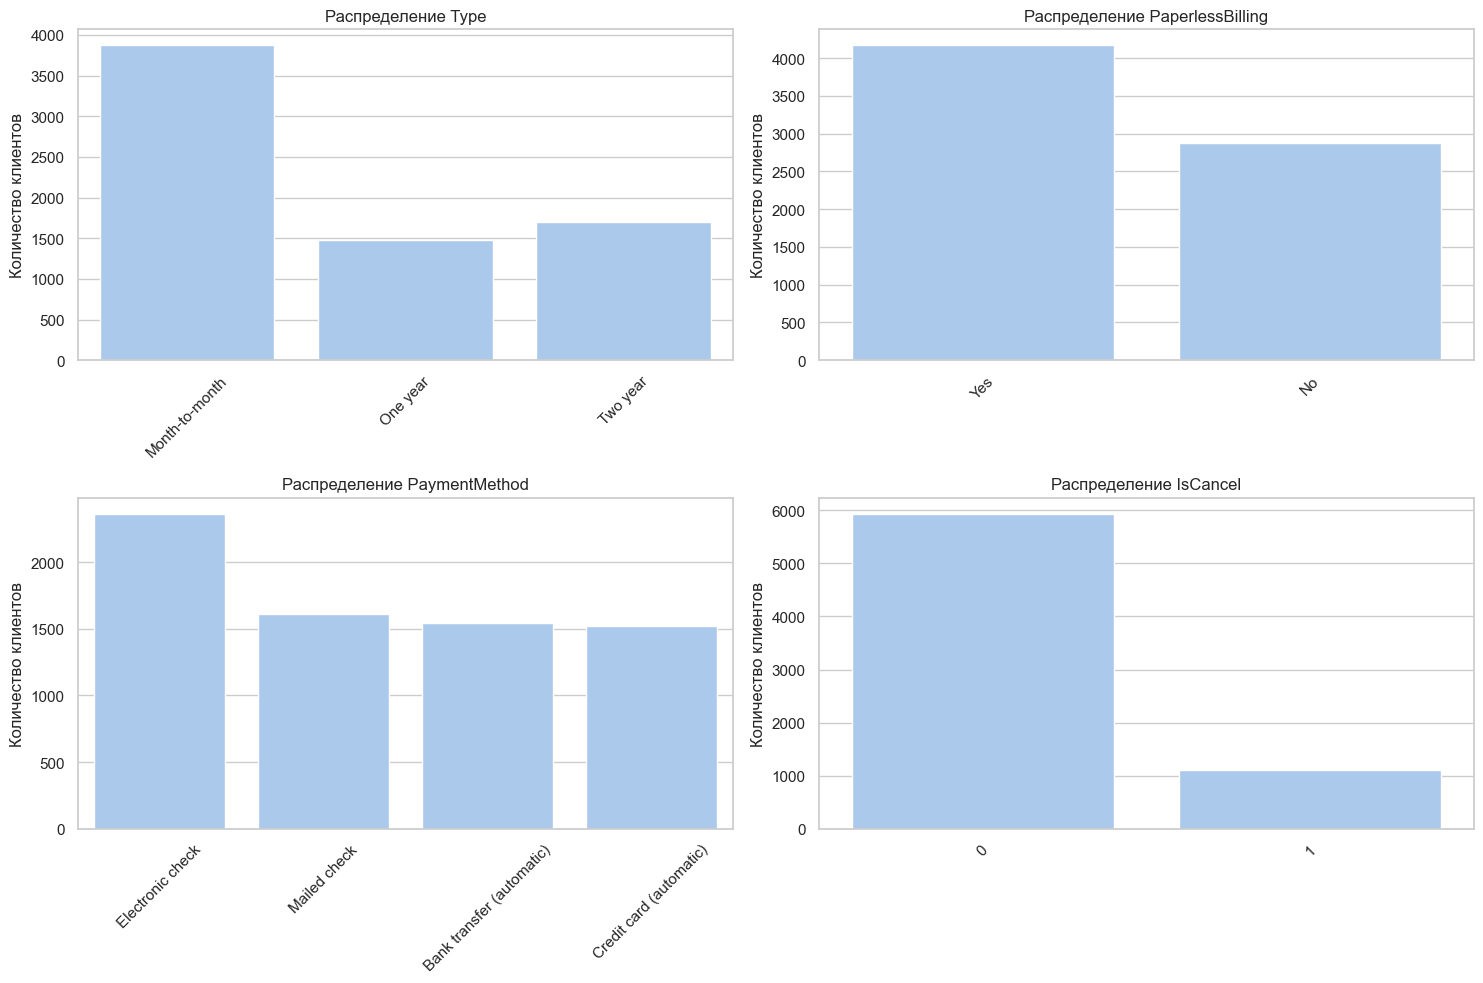

In [415]:
# распределение категориальных признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df_contract, x=feature),#, hue='IsCancel')
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

* больше половины всех договоров оформляется с помесячной оплатой
* в целевом признаке наблюдается дисбаланс, отмененных доворов значительно меньше чем действующих

In [424]:
numeric_features = ['MonthlyCharges', 'TotalCharges', 'DaysActive']

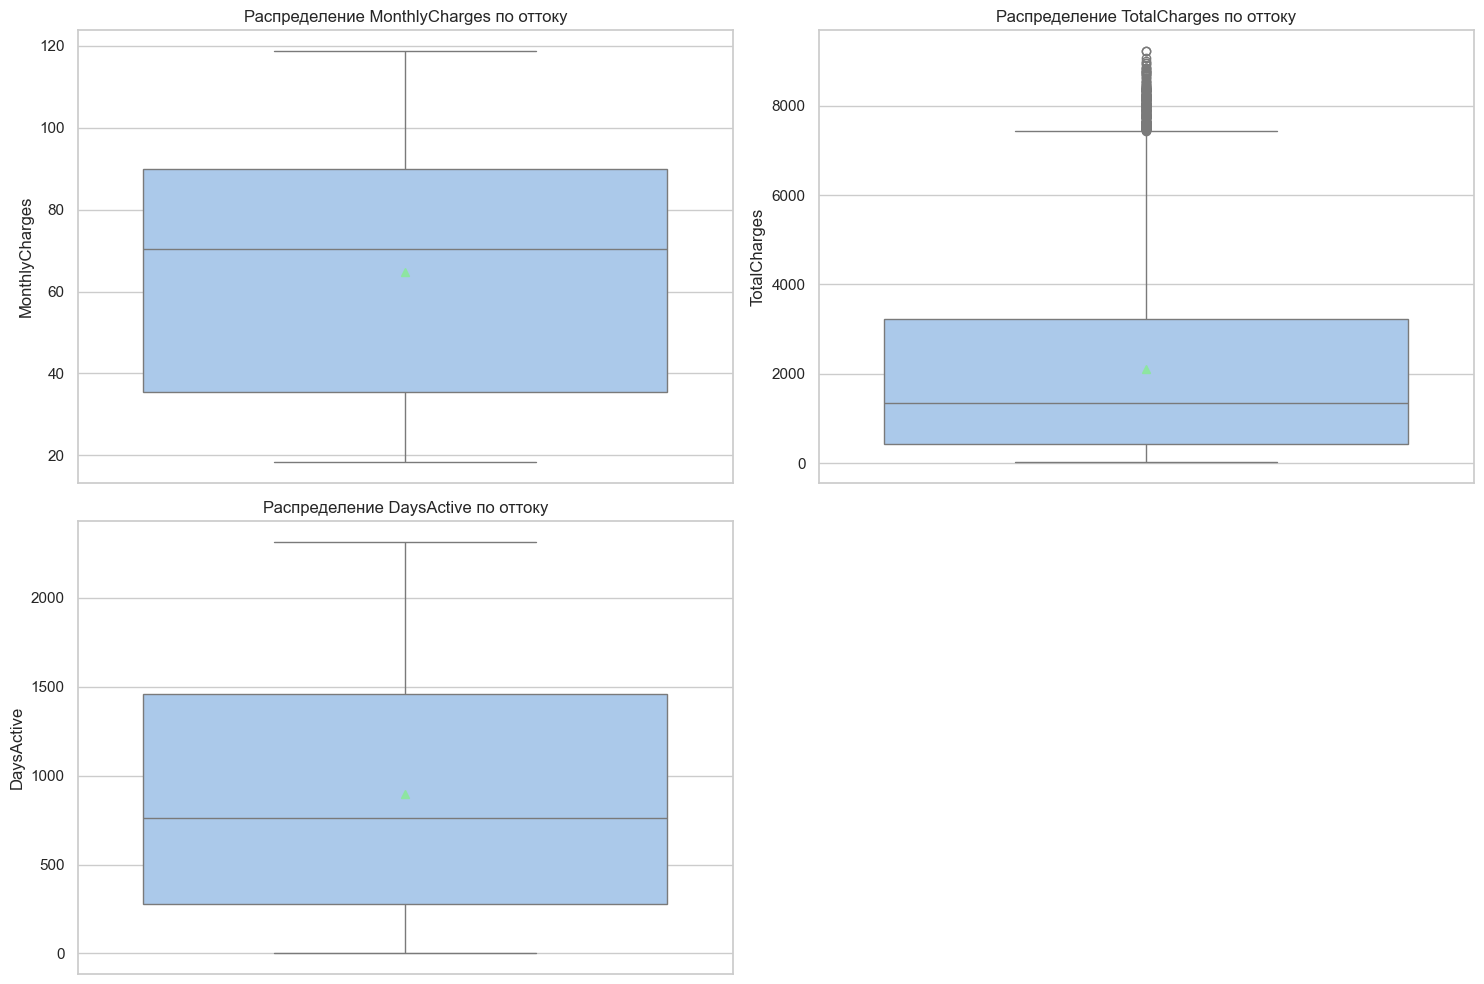

In [426]:
# распределение количественных признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df_contract, y=feature, showmeans=True) # , x='IsCancel'
    plt.title(f'Распределение {feature} по оттоку')
    # plt.xlabel('Отток (0 - активен, 1 - отменил)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

* признаки `MonthlyCharges` и `DaysActive` имеею распределение близкое к нормальному, без выбросов
* признак `TotalyCharges` имеет выбросы в виде сумм более 7500, предположительно это самые первые клиенты

## Таблица personal

In [434]:
# подготовим запрос
query = '''
SELECT 
    *
FROM 
    personal
'''

In [436]:
# загрузим необходимые данные в датафрейм
df_personal = pd.read_sql_query(query, con = engine)

Никаких преобразований делать не будем. Признак `SeniorCitizen` хоть и представлен цифрами, по сути это категориальный признак.

### Визуализация распределения признаков

In [443]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

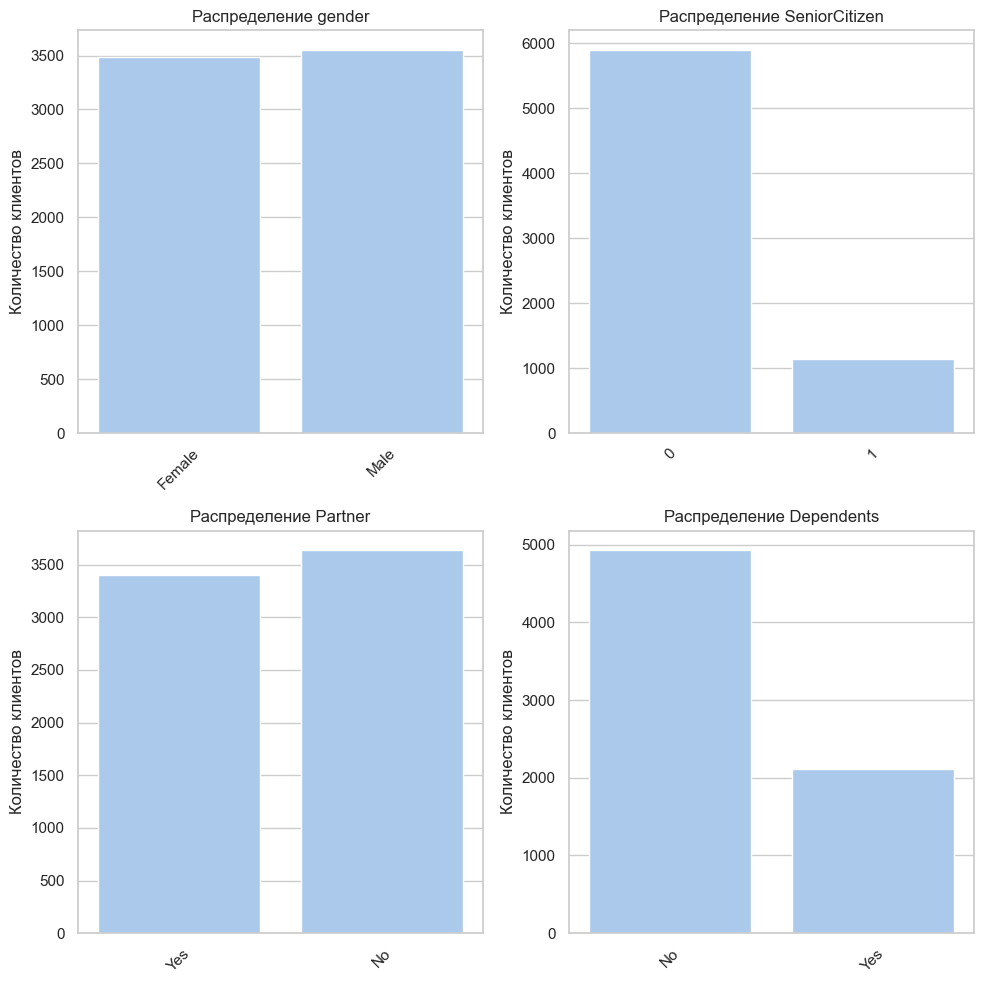

In [445]:
# распределение категориальных признаков
plt.figure(figsize=(10, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df_personal, x=feature)
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

* Мужчины и женщины одинаково заключают одинаковое количество договоров
* Людей пенсионного возраста гораздо меньше чем остальных клиентов
* Женатые и одинокие оформляют одинаковое количество договоров
* Людей с иждивенцами примерно в 2.5 раза меньше, чем людей без них

## Таблица internet

In [449]:
# подготовим запрос
query = '''
SELECT 
    *
FROM 
    internet
'''

In [451]:
# загрузим необходимые данные в датафрейм
df_internet = pd.read_sql_query(query, con = engine)

Преобразований делать не нужно, все признаки категориальные

### Визуализация распределения признаков

In [461]:
categorical_features = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

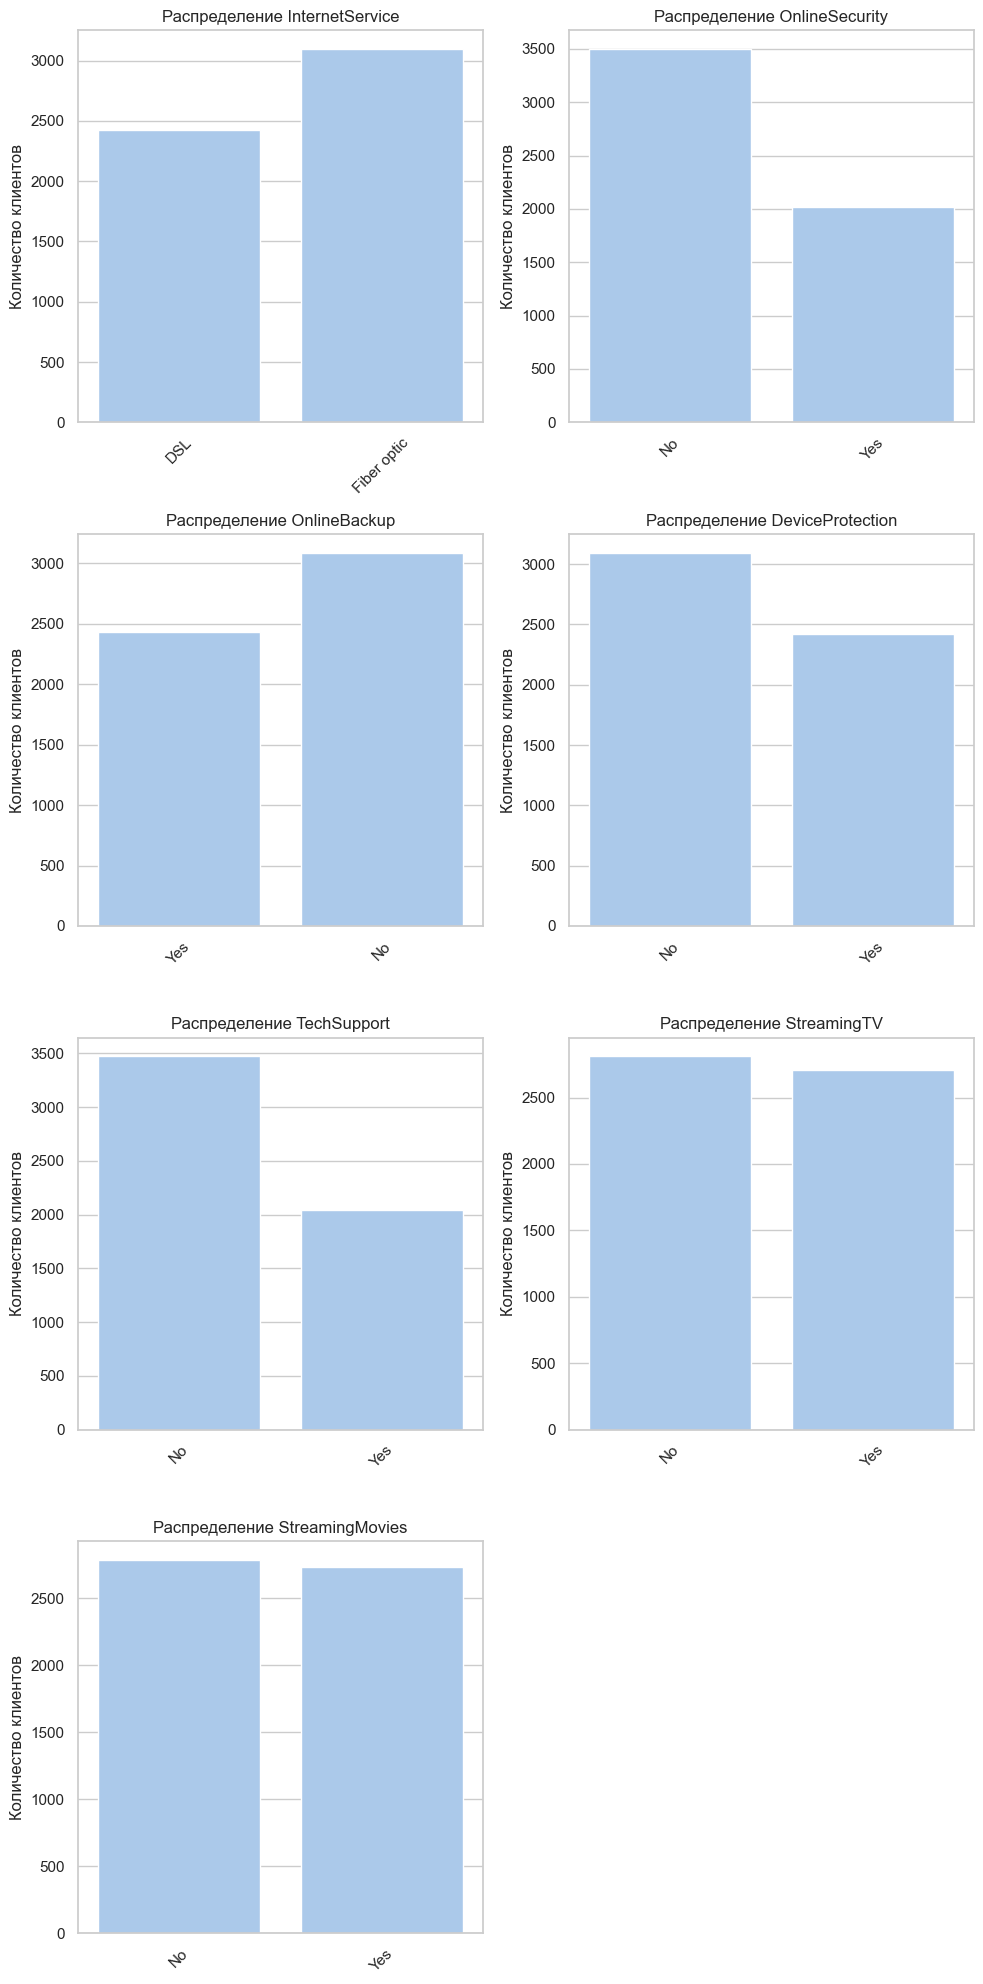

In [463]:
# распределение категориальных признаков
plt.figure(figsize=(10, 20))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=df_internet, x=feature)
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

* распределение интернет услуг между `DSL` и `Fiber optic` примерно равнозначны, `Fiber optic` несколько больше.
* в распределении дополнительных услуг каких-либо аномалий нет. Можно было бы сформировать из наборов услуг нечто похожее на пакеты, чтобы не рассматривать каждую опцию отдельно.

In [474]:
print(f'Количестиво уникальных комбинаций наборов услуг: {len(df_internet[
     ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
 ].apply(lambda x: ''.join(x), axis=1).unique())}')

Количестиво уникальных комбинаций наборов услуг: 64


Выходит слишком много, это увеличит количество признаков, Оставим как есть.

## Объединение датафреймов

In [ ]:
df_final = df

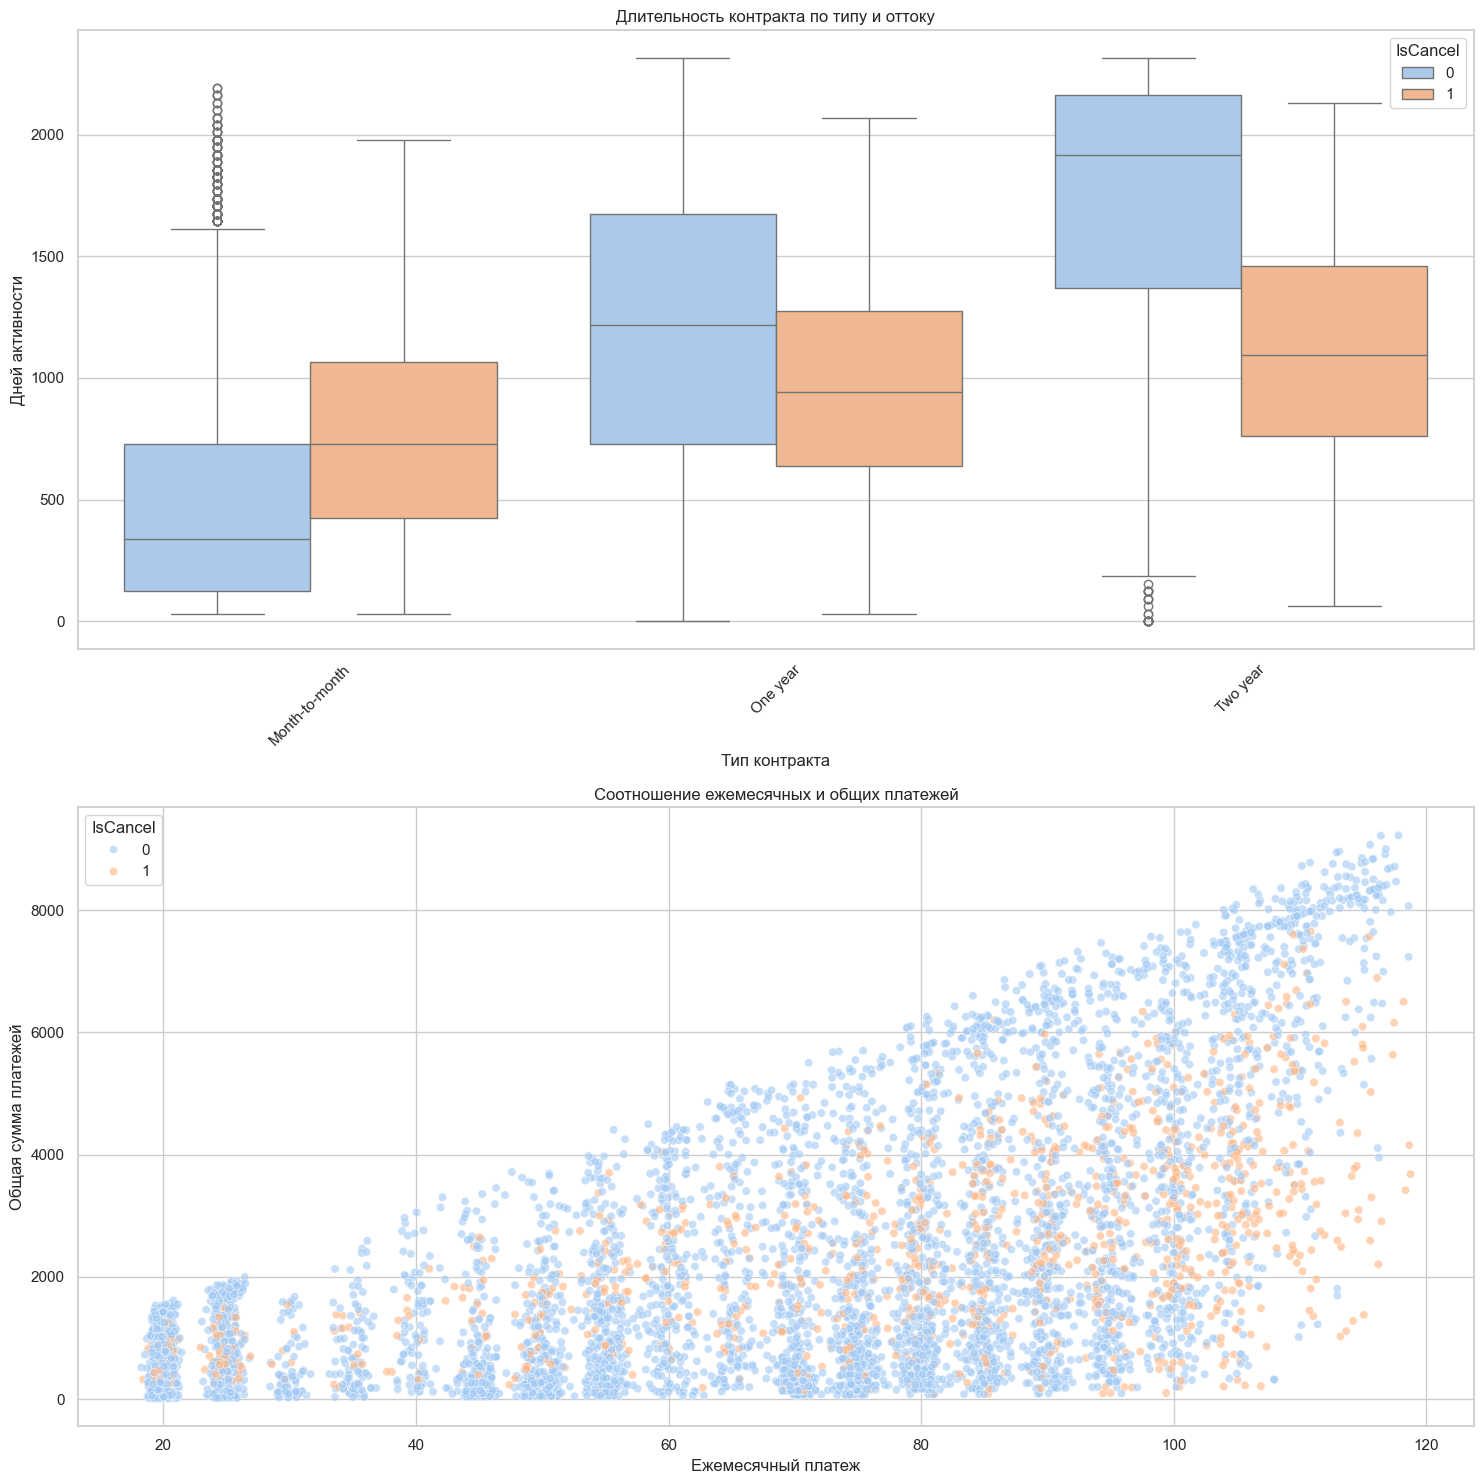

In [305]:
# 3. Дополнительные визуализации
plt.figure(figsize=(15, 15))

# Распределение длительности контракта
plt.subplot(2, 1, 1)
sns.boxplot(data=df_contract, x='Type', y='DaysActive', hue='IsCancel')
plt.title('Длительность контракта по типу и оттоку')
plt.xticks(rotation=45)
plt.xlabel('Тип контракта')
plt.ylabel('Дней активности')

# Распределение платежей
plt.subplot(2, 1, 2)
sns.scatterplot(data=df_contract, x='MonthlyCharges', y='TotalCharges', hue='IsCancel', alpha=0.6)
plt.title('Соотношение ежемесячных и общих платежей')
plt.xlabel('Ежемесячный платеж')
plt.ylabel('Общая сумма платежей')

plt.tight_layout()
plt.show()

## 3. Объединение данных

In [18]:
# # подготовим запрос
# query = '''
# SELECT 
#     con.type AS type,
#     CASE WHEN con.PaperlessBilling = 'Yes' THEN 1 ELSE 0 END AS dig_bill,
#     con.PaymentMethod AS payment,
#     CAST(strftime('%Y', con.BeginDate) AS INTEGER) AS begin,
#     CASE WHEN con.EndDate = 'No' THEN 0 ELSE 1 END AS end,
#     CAST(con.MonthlyCharges AS FLOAT) AS mcharges,
#     CAST(con.TotalCharges AS FLOAT) AS tcharges,
#     CASE 
#         WHEN con.EndDate = 'No' THEN 
#             JULIANDAY('2020-02-01') - JULIANDAY(con.BeginDate)
#         ELSE 
#             JULIANDAY(con.EndDate) - JULIANDAY(con.BeginDate)
#     END AS day_diff,
#     pers.gender AS gender,
#     CAST(pers.SeniorCitizen AS INTEGER) AS senior,
#     CASE WHEN pers.Partner = 'Yes' THEN 1 ELSE 0 END AS partner,
#     CASE WHEN pers.Dependents = 'No' THEN 0 ELSE 1 END AS children,
#     CASE WHEN inet.InternetService IS NULL THEN "No inet" ELSE inet.InternetService END AS internet_service,
#     CASE WHEN inet.OnlineSecurity = 'Yes' THEN 1 ELSE 0 END AS online_security,
#     CASE WHEN inet.OnlineBackup = 'Yes' THEN 1 ELSE 0 END AS online_backup,
#     CASE WHEN inet.DeviceProtection = 'Yes' THEN 1 ELSE 0 END AS device_protection,
#     CASE WHEN inet.TechSupport = 'Yes' THEN 1 ELSE 0 END AS tech_support,
#     CASE WHEN inet.StreamingTV = 'Yes' THEN 1 ELSE 0 END AS streaming_tv,
#     CASE WHEN inet.StreamingMovies = 'Yes' THEN 1 ELSE 0 END AS streaming_movies,
#     CASE WHEN phone.MultipleLines = 'Yes' THEN 1 ELSE 0 END AS multiple_lines
# FROM 
#    contract AS con
# INNER JOIN
#     personal AS pers
# ON con.customerID=pers.customerID
# LEFT JOIN
#    internet AS inet
# ON con.customerID=inet.customerID
# LEFT JOIN
#    phone AS phone
# ON con.customerID=phone.CustomeriD

# '''

In [19]:
# загрузим необходимые данные в датафрейм
df = pd.read_sql_query(query, con = engine)

In [20]:
engine.dispose()

In [291]:
df['tcharges'].describe()

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: tcharges, dtype: float64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   dig_bill           7043 non-null   int64  
 2   payment            7043 non-null   object 
 3   begin              7043 non-null   int64  
 4   end                7043 non-null   int64  
 5   mcharges           7043 non-null   float64
 6   tcharges           7043 non-null   float64
 7   day_diff           7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior             7043 non-null   int64  
 10  partner            7043 non-null   int64  
 11  children           7043 non-null   int64  
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   int64  
 14  online_backup      7043 non-null   int64  
 15  device_protection  7043 non-null   int64  
 16  tech_support       7043 

In [23]:
df.sample(10)

,type,dig_bill,payment,begin,end,mcharges,tcharges,day_diff,gender,senior,partner,children,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
3889,One year,0,Credit card (automatic),2019,0,19.30,253.41,396.0,Male,0,0,0,No inet,0,0,0,0,0,0,0
5629,Month-to-month,0,Mailed check,2019,0,20.05,40.10,62.0,Male,1,0,0,No inet,0,0,0,0,0,0,0
5456,Month-to-month,1,Electronic check,2018,0,31.05,456.44,427.0,Female,0,0,0,DSL,0,1,0,0,0,0,0
2969,Two year,0,Electronic check,2014,0,109.30,7175.55,1979.0,Female,0,1,1,Fiber optic,1,0,1,1,1,1,1
353,Month-to-month,1,Bank transfer (automatic),2019,0,84.80,593.60,215.0,Male,0,1,1,Fiber optic,0,1,1,0,0,0,1
6272,One year,1,Electronic check,2015,1,61.00,2772.45,1369.0,Male,0,0,1,DSL,0,1,1,1,0,0,0
4337,Month-to-month,1,Credit card (automatic),2014,0,99.65,7075.15,2163.0,Female,1,0,0,Fiber optic,0,1,0,0,1,1,1
4933,Month-to-month,1,Mailed check,2019,0,57.20,228.80,123.0,Female,0,0,1,DSL,1,1,1,0,1,1,0
2961,Month-to-month,1,Mailed check,2019,0,53.75,664.35,365.0,Male,0,0,0,DSL,0,1,0,1,0,0,0
286,Month-to-month,1,Electronic check,2018,0,44.35,922.48,610.0,Female,0,0,0,DSL,0,0,0,0,0,0,0


In [24]:
df['type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [25]:
df['payment'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [26]:
df['begin'].unique()

array([2020, 2017, 2019, 2016, 2018, 2014, 2015, 2013], dtype=int64)

In [27]:
df['internet_service'].unique()

array(['DSL', 'Fiber optic', 'No inet'], dtype=object)

In [28]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [29]:
categorical_features = ['type', 'payment', 'begin', 'internet_service', 'gender']

In [30]:
df['additional_services'] = df[
     ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
 ].astype(str).apply(lambda x: ''.join(x), axis=1)

In [31]:
# df['additional_services_count'] = df[
#     ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
# ].apply(lambda x: sum(x), axis=1)

In [32]:
df = df.drop(['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'], axis=1)

In [33]:
df['upper_costs'] = (df['tcharges'] - (df['day_diff'] / 30.4) * df['mcharges']) > df['mcharges']

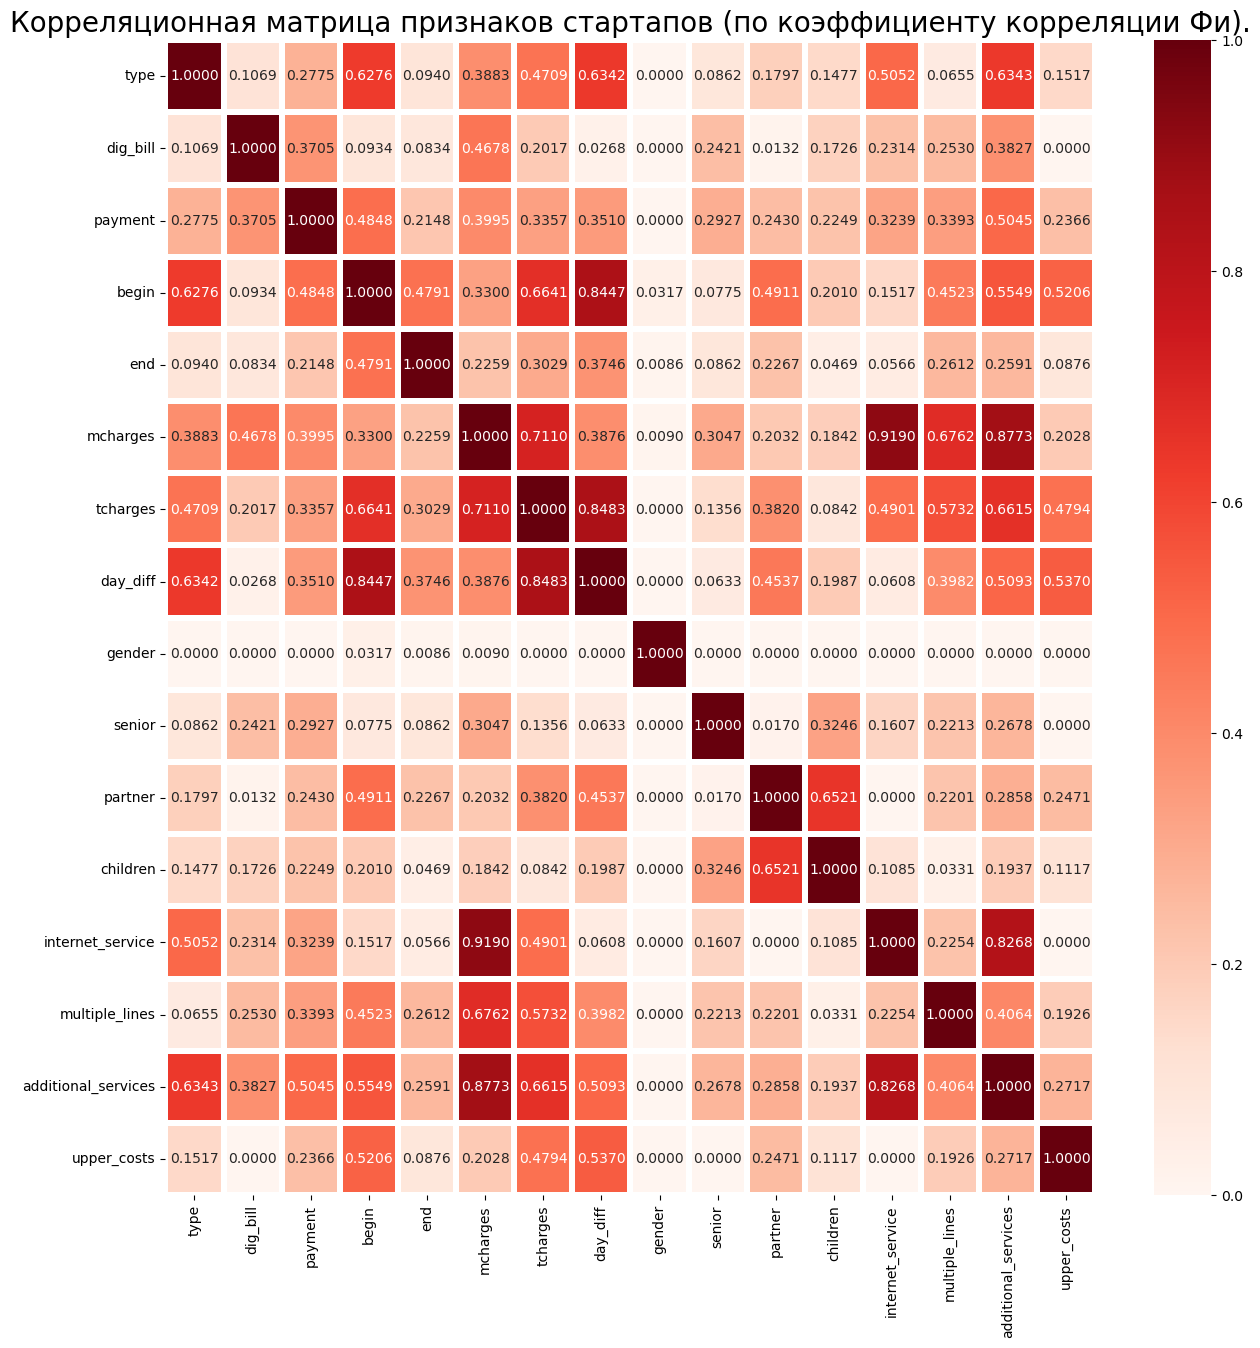

In [34]:
# определяем перечень непрерывных количественных столбцов для построения матрицы 
interval_cols = ['mcharges', 'tcharges', 'day_diff']

# строим матрицу корреляции
plt.figure(figsize=(15,15))
sns.heatmap(
    df.phik_matrix(
        interval_cols=interval_cols,
        verbose=False
    ),
    annot=True,
    cmap='Reds',
    fmt='.4f',
    linewidths=3
)
plt.title('Корреляционная матрица признаков стартапов (по коэффициенту корреляции Фи).', fontsize=20)
plt.show()

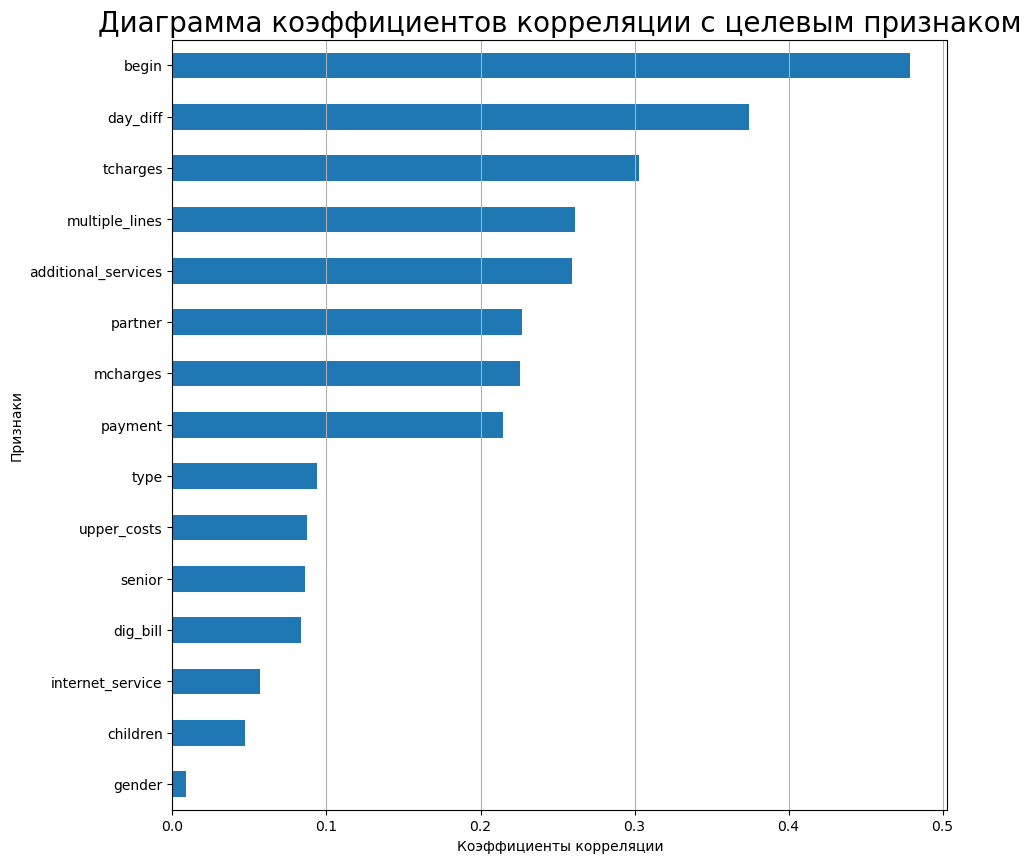

In [35]:
# построим диаграмму коэффициентов корреляции с целевым признаком
plt.figure(figsize=(10,10))
df.phik_matrix(
        interval_cols=interval_cols,
        verbose=False
)[TARGET].sort_values()[:-1].plot.barh()
plt.grid(axis='x')
plt.title('Диаграмма коэффициентов корреляции с целевым признаком', fontsize=20)
plt.xlabel('Коэффициенты корреляции')
plt.ylabel('Признаки')
plt.show()

In [36]:
df = df.drop('begin', axis=1)
#df = df.drop('day_diff', axis=1)
#df = df.drop('tcharges', axis=1)
#df = df.drop('gender', axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET, axis=1),
    df[TARGET],
    test_size=TEST_SIZE,
    stratify = df[TARGET],
    random_state=RANDOM_STATE
)

print(f"Тренировочная выборка: {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")

Тренировочная выборка: (5282, 14), (5282,)
Тестовая выборка: (1761, 14), (1761,)


In [38]:
categorical_features = [
    'type', 'payment', 'gender', 'internet_service', 'additional_services', 'upper_costs', 'senior', 'partner','children'
] #'begin','gender',
num_features = [x for x in X_train.columns if x not in categorical_features]

In [39]:
X_train.isna().sum()

type                   0
dig_bill               0
payment                0
mcharges               0
tcharges               0
day_diff               0
gender                 0
senior                 0
partner                0
children               0
internet_service       0
multiple_lines         0
additional_services    0
upper_costs            0
dtype: int64

# Обучение моделей

In [41]:
# создадим словарь для хранения метрик и времени обучения моделей
best_models = {'model':[], 'ROC-AUC_cv':[],
               'train_time_cv':[], 'ROC-AUC':[]}

In [42]:
# функция считает метрику заданной модели на тестовых данных
# и записывает в массив
def get_metrics(X, y, model, metrics_arr, n=3):
    y_pred_proba = model.predict_proba(X)[:, 1]
    roc_auc = roc_auc_score(y, y_pred_proba)
    metrics_arr['ROC-AUC'].append(round(roc_auc, n))
    return metrics_arr

## CatBoostClassifier

In [44]:
# параметры модели CatBoostClassifier
params_grid_cb = {
    'iterations': [250, 350, 450],
    'learning_rate': [.01, .05, .1],
    'depth': [5, 10],
    'verbose': [False],
    'eval_metric': ['AUC'],
    'random_state': [RANDOM_STATE]
}

In [45]:
# Настройка GridSearchCV для CatBoostClassifier
grid_cb = GridSearchCV(
    estimator=CatBoostClassifier(cat_features=categorical_features),
    param_grid=params_grid_cb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [46]:
# обучение модели на кросс-валидации + вывод лучших параметров
best_models['model'].append('CatBoostClassifier')
grid_cb.fit(
    X_train,
    y_train
)
best_models['ROC-AUC_cv'].append(grid_cb.best_score_)
best_models['train_time_cv'].append(
    round(grid_cb.cv_results_['mean_fit_time'][grid_cb.best_index_], 4)
)
print('Подобранные гиперпараметры:')
for param, value in grid_cb.best_params_.items():
    print(f'{param}: {value}')

Подобранные гиперпараметры:
depth: 5
eval_metric: AUC
iterations: 450
learning_rate: 0.1
random_state: 110825
verbose: False


In [47]:
# выбираем лучшую обученную модель
best_model_cb = grid_cb.best_estimator_

In [48]:
# оцениваем модель на тестовых данных
best_models = get_metrics(X_test, y_test, best_model_cb, best_models)

## LogisiticRegression

In [50]:
# пайплайн для OHE кодирования признаков. пропуски заменям модой.
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [51]:
# пайплайн для масштабирования количественных признаков, пропуски заполеям медианой
num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [52]:
# пайплайн для кодирования и масштабирования всех признаков
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, categorical_features),
        ('num', num_pipe, num_features)
    ], 
    remainder='passthrough'
)

In [53]:
# финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
) 

In [54]:
param_grid_lr = [    
    {
        'models': [
            LogisticRegression()
        ],
        'models__C': [0.1, 1, 10],
        'models__penalty': ['l2'],
        'models__solver': ['lbfgs', 'liblinear'],
        'models__class_weight': ['balanced']
    }
]

In [55]:
# Настройка GridSearchCV для LinearRegression
grid_lr = GridSearchCV(
    pipe_final,
    param_grid_lr,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

In [56]:
# обучение модели на кросс-валидации + вывод лучших параметров
best_models['model'].append('LogisticRegression')
grid_lr.fit(
    X_train,
    y_train
)
best_models['ROC-AUC_cv'].append(grid_lr.best_score_)
best_models['train_time_cv'].append(
    round(grid_lr.cv_results_['mean_fit_time'][grid_lr.best_index_], 4)
)
print('Подобранные гиперпараметры:')
for param, value in grid_lr.best_params_.items():
    print(f'{param}: {value}')

Подобранные гиперпараметры:
models: LogisticRegression()
models__C: 0.1
models__class_weight: balanced
models__penalty: l2
models__solver: lbfgs


In [57]:
# выбираем лучшую обученную модель
best_model_lr = grid_lr.best_estimator_

In [58]:
# оцениваем модель на тестовых данных
best_models = get_metrics(X_test, y_test, best_model_lr, best_models)

## RandomForestClassifier

In [60]:
# параметры модели RandomForestClassifier
param_grid_rf = [
    {
        'models': [
            RandomForestClassifier(random_state=RANDOM_STATE)
        ],
        'models__n_estimators': [200, 300, 350],
        'models__max_depth': [5, 8, 10],
        'models__min_samples_split': [5, 10, 15],
        'models__min_samples_leaf': [2, 4],
        'models__class_weight': ['balanced']
    }
]     

In [61]:
# Настройка GridSearchCV для RandomForestClassifier
grid_rf = GridSearchCV(
    pipe_final,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [62]:
# обучение модели на кросс-валидации + вывод лучших параметров
best_models['model'].append('RandomForestClassifier')
grid_rf.fit(
    X_train,
    y_train
)
best_models['ROC-AUC_cv'].append(grid_rf.best_score_)
best_models['train_time_cv'].append(
    round(grid_rf.cv_results_['mean_fit_time'][grid_rf.best_index_], 4)
)
print('Подобранные гиперпараметры:')
for param, value in grid_rf.best_params_.items():
    print(f'{param}: {value}')

Подобранные гиперпараметры:
models: RandomForestClassifier(random_state=110825)
models__class_weight: balanced
models__max_depth: 10
models__min_samples_leaf: 2
models__min_samples_split: 15
models__n_estimators: 200


In [63]:
# выбираем лучшую обученную модель
best_model_rf = grid_rf.best_estimator_

In [64]:
# оцениваем модель на тестовых данных
best_models = get_metrics(X_test, y_test, best_model_rf, best_models)

In [65]:
# создаем датафрейм с метриками моделей
models_results = pd.DataFrame(
    best_models, columns=[
        'model', 'ROC-AUC_cv',
        'train_time_cv', 'ROC-AUC'
    ]
)
models_results

,model,ROC-AUC_cv,train_time_cv,ROC-AUC
0,CatBoostClassifier,0.881555,23.8193,0.905
1,LogisticRegression,0.762430,0.0733,0.743
2,RandomForestClassifier,0.818851,0.8763,0.813


# Оценка важности признаков

In [67]:
# выбираем LR в качестве финальной модели
final_model = grid_cb.best_estimator_

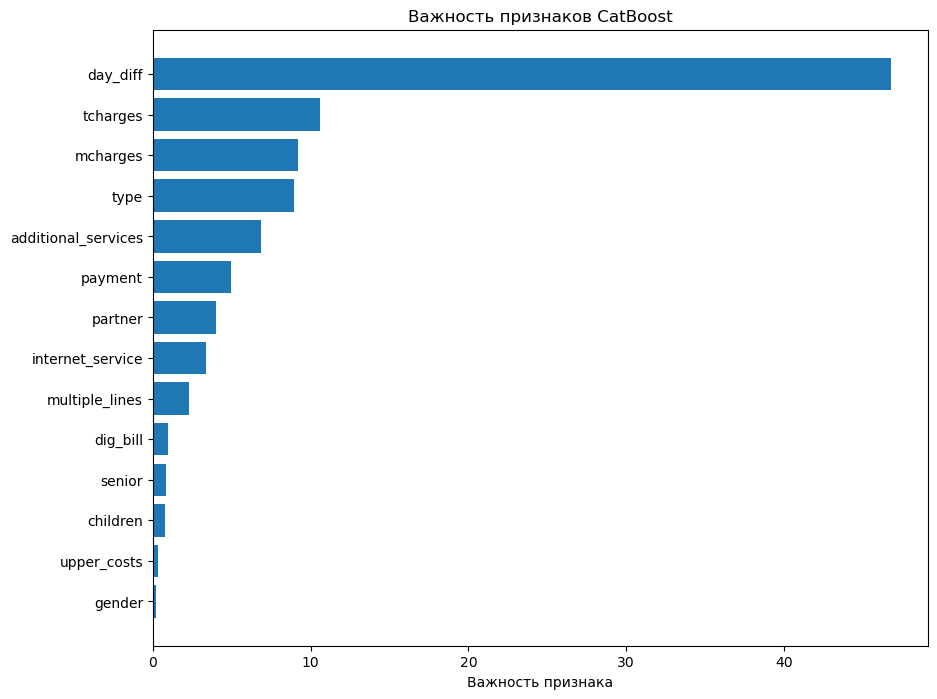

In [68]:
# Получаем важность признаков из CatBoost
feature_importance = final_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)

# Строим обычный bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.xlabel('Важность признака')
plt.title('Важность признаков CatBoost')
plt.show()